# Phase transition

In [2]:
from qiskit.quantum_info import Statevector, SparsePauliOp, Operator 

import itertools as it
import scipy.sparse.linalg as ssla
from scipy import sparse
import pandas as pd

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import numpy as np

from utils import *
from dqpt import *
from spin_ham import *

## Symmetry protected topological (SPT) phase

one-dimensional cluster-Ising model 
$$H = -\sum_{i=1}^{N-2} Z_i X_{i+1} Z_{i+2} - h_1 \sum_{i=1}^N X_i - h_2 \sum_{i=1}^{N-1} X_iX_{i+1} $$

https://arxiv.org/abs/1810.03787

In [35]:
class Cluster_Ising:
    def __init__(self, n: int, h1, h2, verbose):
        self.n = n
        self.h1 = h1
        self.h2 = h2
        self.verbose = verbose

        self.H = SparsePauliOp.from_list([['I'*n, 0]])

        for i in range(n-2):
            self.H += SparsePauliOp.from_list([['I'*i + 'ZXZ' + 'I'*(n-i-3), -1]])
            self.H += SparsePauliOp.from_list([['I'*i + 'X' + 'I'*(n-i-1), -h1]])
            self.H += SparsePauliOp.from_list([['I'*i + 'XX' + 'I'*(n-i-2), -h2]])

        self.H += SparsePauliOp.from_list([['I'*(n-2)+'XI', -h1], ['I'*(n-1)+'X', -h1]])
        self.H += SparsePauliOp.from_list([['I'*(n-2)+'XX', -h2]])

        self.H.simplify()
        order_string = ''
        for i in range(1, n+1):
            if i == 1:
                order_string += 'Z'
            elif i % 2 == 0:
                order_string += 'X'
            elif i == n:
                order_string += 'Z'
            else:
                order_string += 'I'
        if verbose: print('order string: ', order_string)
        self.string_order = SparsePauliOp.from_list([[order_string, 1]])


In [87]:
import matplotlib.colors as colors

h1_list = np.linspace(0, 2, 50)
h2_list = np.linspace(-2, 2, 50)
h1_mesh , h2_mesh = np.meshgrid(h1_list, h2_list)
exp_vals = np.zeros((len(h1_list), len(h2_list)), dtype=np.complex128)

for i1, h1 in enumerate(h1_list):
    for i2, h2 in enumerate(h2_list):
        n = 5 # number of spins (should be at least odd number)
        ci = Cluster_Ising(n, h1=h1, h2=h2, verbose=False) # create a cluster Ising model with n spins, h1=1, h2=2

        # print(ci.H) # print the Hamiltonian
        # print(ci.string_order) # print the string order operator

        # ground state of the Hamiltonian
        gnd_st = np.linalg.eigh(ci.H.to_matrix())[1][:,0]
        ob = ci.string_order.to_matrix()
        exp_val = np.dot(np.conj(gnd_st), np.dot(ob, gnd_st))
        exp_vals[i2, i1] = exp_val

# print(exp_vals)

Text(0.2, 0.4, 'SPT')

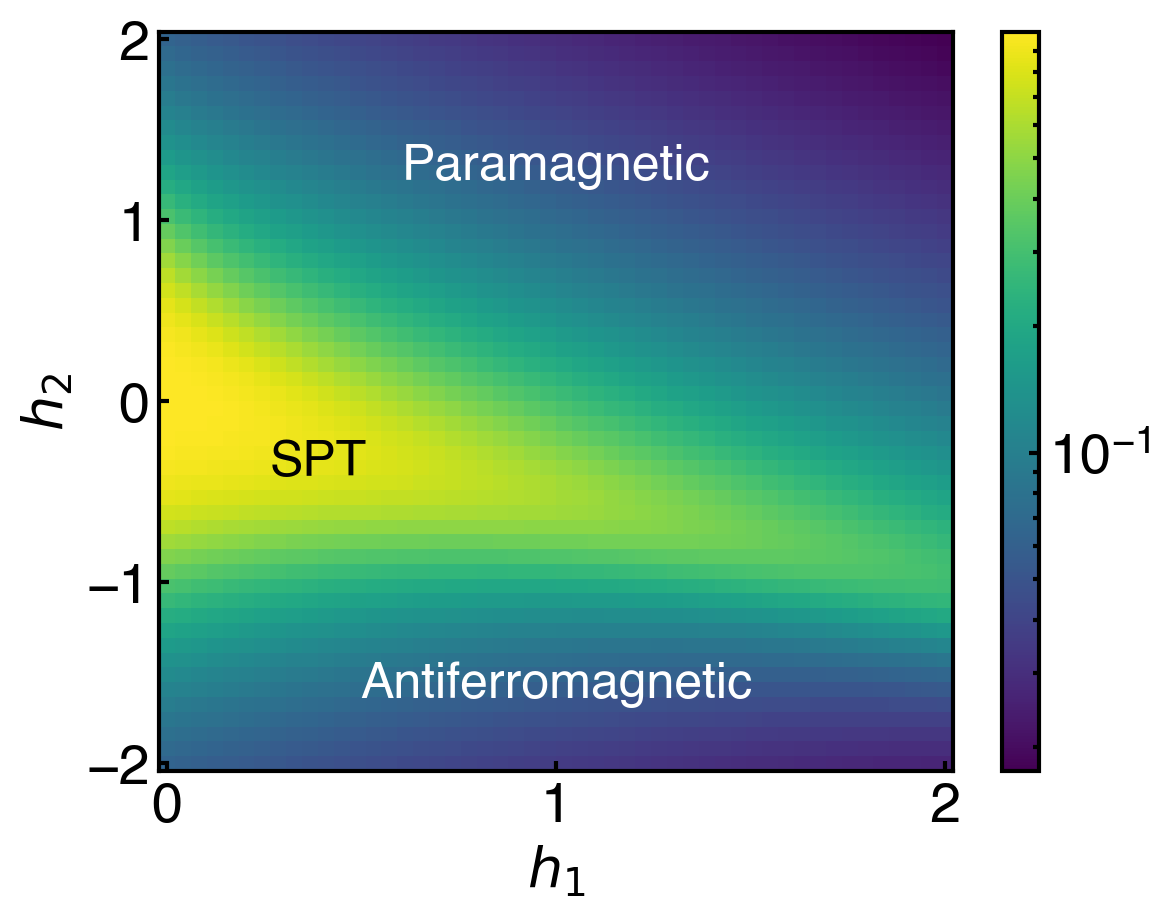

In [88]:
fig, ax = plt.subplots()
z = np.real(exp_vals)
c = ax.pcolormesh(h1_mesh, h2_mesh, z, norm=colors.LogNorm(vmin=z.min(), vmax=z.max())) 
fig.colorbar(c, ax=ax)  # , extend='max'
ax.set_xlabel(r'$h_1$')
ax.set_ylabel(r'$h_2$')
ax.annotate(r'Paramagnetic', xy=(0.5, 0.8), xycoords='axes fraction', ha='center', fontsize=18, color='white')
ax.annotate(r'Antiferromagnetic', xy=(0.5, 0.1), xycoords='axes fraction', ha='center', fontsize=18, color='white')
ax.annotate(r'SPT', xy=(0.2, 0.4), xycoords='axes fraction', ha='center', fontsize=18, color='k')

## Dynamical quantum phase transition
http://arxiv.org/abs/1709.07461

The Hamiltonian: 
 SparsePauliOp(['IIIIXX', 'IIIXXI', 'IIXXII', 'IXXIII', 'XXIIII', 'IIIIYY', 'IIIYYI', 'IIYYII', 'IYYIII', 'YYIIII', 'IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII', 'IIIIIX', 'IIIIXI', 'IIIXII', 'IIXIII', 'IXIIII', 'XIIIII'],
              coeffs=[-0. +0.j, -0. +0.j, -0. +0.j, -0. +0.j, -0. +0.j, -0. +0.j, -0. +0.j,
 -0. +0.j, -0. +0.j, -0. +0.j, -1. +0.j, -1. +0.j, -1. +0.j, -1. +0.j,
 -1. +0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j, -0.2+0.j])


Text(0.5, 0, 'Time')

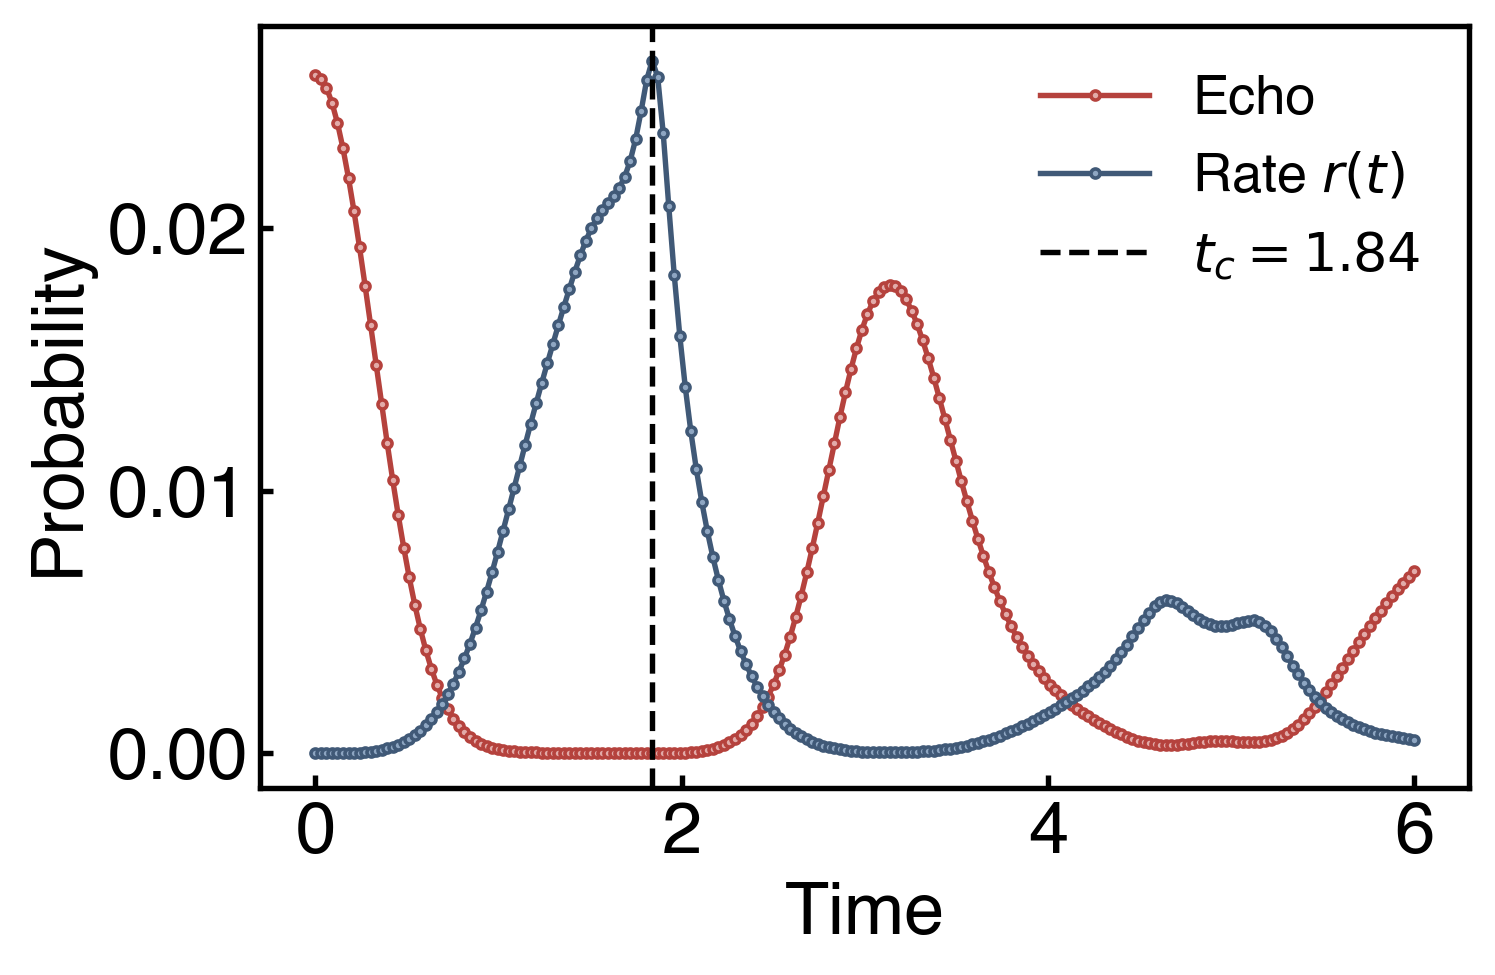

In [3]:
n = 6
r_pf = 50
t_max, t_n = 6.0, 200
t_list = np.linspace(0, t_max, t_n)

H = Heisenberg_1d(n, Jx=0.0, Jy=0.0, Jz=1.0, h=0.2, verbose=True).ham
init_state = Statevector.from_label('+'*n)
echo_list = []

for t in t_list:
    final_state = expm(-1j * t * H.to_matrix()) @ init_state.data
    echo = np.abs(init_state.data.conj() @ final_state)**2
    # print('echo: ', echo)
    echo_list.append(echo)
rate_list = [-np.log(echo)/n for echo in echo_list]

fig, ax= plt.subplots(1, 1, figsize=(6, 4), layout='tight', sharex=True)

plot_evo(ax, t_list, echo_list/sum(echo_list), '.-', ylabel='Percent', label='Echo')
plot_evo(ax, t_list, normalize(rate_list), '.-', ylabel='Probability', label=rf'Rate $r(t)$')
t_c = t_list[np.argmin(echo_list)]
ax.axvline(t_c, ls='--', color='k', label=f'$t_c = {t_c:.2f}$')

ax.legend() 
ax.set_xlabel('Time')

## Equilibrium quantum phase transition

## Statistical phase transition